In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import classification_report
RANDOM_SEED = 42
%matplotlib inline

Using TensorFlow backend.


In [2]:
dataset_path = './Dataset/'
person_folders = os.listdir(dataset_path)
print(person_folders)

df = pd.DataFrame()
df_list = []

for i in range(len(person_folders)):
    person_folder = person_folders[i]
    csv_file_path = dataset_path + person_folder + '/'
    csv_files = os.listdir(csv_file_path)

    for j in range(len(csv_files)):
        csv_file = csv_files[j]
        #print(csv_file)

        data_frame = pd.read_csv(csv_file_path + '/' + csv_file, index_col=None, header=None)
        df_list.append(data_frame)

df = pd.concat(df_list, axis = 0, sort= True, ignore_index = True)
df.columns = ['Timestamp', 'Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz', 'Label', 'Activity']

['P1', 'P2', 'P3', 'P4', 'P5', 'P6']


In [3]:
print(df.count())
df.head()

Timestamp    105881
Ax           105881
Ay           105881
Az           105881
Gx           105881
Gy           105881
Gz           105881
Label        105881
Activity     105881
dtype: int64


,Timestamp,Ax,Ay,Az,Gx,Gy,Gz,Label,Activity
0,1.564040e+12,0.499756,0.798584,-0.313110,-16.768293,-10.091463,11.189024,4,Eating
1,1.564040e+12,0.497314,0.826172,-0.312622,-6.981707,-11.310976,10.731707,4,Eating
2,1.564040e+12,0.495605,0.825562,-0.313477,-5.823171,-11.402439,3.993902,4,Eating
3,1.564040e+12,0.493408,0.823242,-0.314697,-5.091463,-11.067073,6.890244,4,Eating
4,1.564040e+12,0.495605,0.819336,-0.315552,-4.115854,-11.189024,16.890244,4,Eating


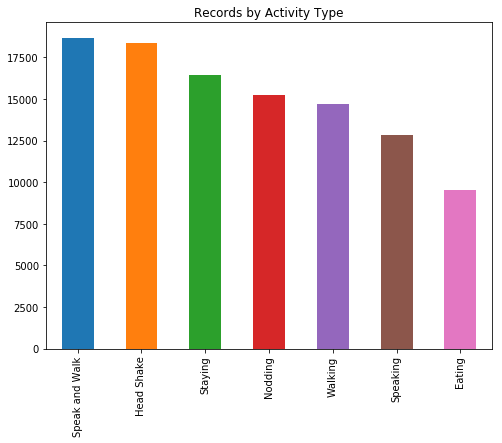

In [4]:
df['Activity'].value_counts().plot(kind='bar', title='Records by Activity Type', figsize=(8, 6),align='center');

In [5]:
# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'

df['Ax'] = df['Ax'] / df['Ax'].max()
df['Ay'] = df['Ay'] / df['Ay'].max()
df['Az'] = df['Az'] / df['Az'].max()

df['Gx'] = df['Gx'] / df['Gx'].max()
df['Gy'] = df['Gy'] / df['Gy'].max()
df['Gz'] = df['Gz'] / df['Gz'].max()

# Round numbers
df = df.round({'Ax': 5, 'Ay': 5, 'Az': 5, 'Gx': 5, 'Gy': 5, 'Gz': 5})

In [6]:
N_TIME_STEPS = 80
N_FEATURES = 6
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    Ax = df['Ax'].values[i: i + N_TIME_STEPS]
    Ay = df['Ay'].values[i: i + N_TIME_STEPS]
    Az = df['Az'].values[i: i + N_TIME_STEPS]
    
    Gx = df['Gx'].values[i: i + N_TIME_STEPS]
    Gy = df['Gy'].values[i: i + N_TIME_STEPS]
    Gz = df['Gz'].values[i: i + N_TIME_STEPS]
    
    label = stats.mode(df['Activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([Ax, Ay, Az, Gx, Gy, Gz])
    labels.append(label)

C:\Users\admin\Anaconda3\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


In [7]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

In [9]:
print('X_train : ', X_train.shape)
print('X_test : ', X_test.shape)

X_train :  (4232, 80, 6)
X_test :  (1059, 80, 6)


In [10]:
verbose = 1
epochs = 50
batch_size = 100

n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = y_train.shape[1]

print('n_timesteps : ', n_timesteps)
print('n_features : ', n_features)
print('n_outputs : ', n_outputs)

n_timesteps :  80
n_features :  6
n_outputs :  7


In [11]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding = 'same'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
# fit network
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=epochs, batch_size=batch_size, verbose=verbose)
# evaluate model
(loss, accuracy) = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=verbose)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss, accuracy * 100))

Train on 4232 samples, validate on 1059 samples
Epoch 1/50
4232/4232 [==============================] - 3s 788us/step - loss: 1.0188 - acc: 0.6151 - val_loss: 0.5761 - val_acc: 0.8149: 1.24
Epoch 2/50
4232/4232 [==============================] - 3s 657us/step - loss: 0.4747 - acc: 0.8228 - val_loss: 0.4950 - val_acc: 0.8234
Epoch 3/50
4232/4232 [==============================] - 3s 655us/step - loss: 0.3922 - acc: 0.8495 - val_loss: 0.3923 - val_acc: 0.8669
Epoch 4/50
4232/4232 [==============================] - 3s 708us/step - loss: 0.3686 - acc: 0.8518 - val_loss: 0.3990 - val_acc: 0.8716
Epoch 5/50
4232/4232 [==============================] - 3s 753us/step - loss: 0.3236 - acc: 0.8771 - val_loss: 0.3413 - val_acc: 0.8829
Epoch 6/50
4232/4232 [==============================] - 3s 651us/step - loss: 0.2944 - acc: 0.8816 - val_loss: 0.3393 - val_acc: 0.87350.2959 - acc
Epoch 7/50
4232/4232 [==============================] - 3s 658us/step - loss: 0.2727 - acc: 0.8913 - val_loss: 0.3128 

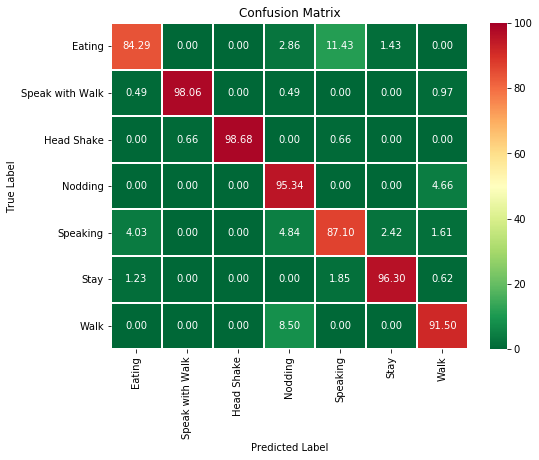

              precision    recall  f1-score   support

           0       0.88      0.84      0.86        70
           1       1.00      0.98      0.99       206
           2       1.00      0.99      0.99       151
           3       0.89      0.95      0.92       193
           4       0.90      0.87      0.89       124
           5       0.97      0.96      0.97       162
           6       0.91      0.92      0.91       153

   micro avg       0.94      0.94      0.94      1059
   macro avg       0.94      0.93      0.93      1059
weighted avg       0.94      0.94      0.94      1059



In [13]:

# Print confusion matrix for training data
y_pred_train = model.predict(X_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
#print(classification_report(trainy, max_y_pred_train))

# confusion matrix
LABELS = [ 'Eating',
            'Speak with Walk',
          'Head Shake',
          'Nodding',
        'Speaking',      
         'Stay', 
          'Walk']
y_pred_test = model.predict(X_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

matrix = metrics.confusion_matrix(max_y_test, max_y_pred_test)
matrix = (matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis])*100
fmt = '.2f'
plt.figure(figsize=(8, 6))
sns.heatmap(matrix,
            cmap='RdYlGn_r',
            linecolor='white',
            linewidths=1,
            xticklabels= LABELS,
            yticklabels= LABELS,
            annot=True,
            fmt=fmt,
           vmax = 100)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(max_y_test, max_y_pred_test))